# Process log data

In [1]:
import os, sys, shutil, csv, re
import pandas as pd
import numpy as np

csv_cols = ['cores', 'backend', 'part_size', 'part_type', 
            'test_type', 'size(MiB)', 'time(s)', 'speed(MiB/s)']
#parse macsio log files and generate .csv files
def parse_logs(target_dir):
    all_info = []

    for parent, dirnames, filenames in os.walk(target_dir, followlinks=True):
        for filename in filenames:
            if 'log-' not in filename:
                continue
#             print(filename)
            name_t = filename.split('-')
            backend = name_t[1]
            part_size = name_t[2]
            part_type = name_t[3]
            test_type = name_t[4]
            cores = name_t[5].split('.')[0][1:]

            with open(parent+'/'+filename, 'r') as f:
                for line in f:
                    if 'Total Bytes' in line:
                        pattern_str = r"\s(\d+.\d+)\s([M|G|K]i).+?\s(\d+.\d+)\s(m?secs|mins).+?(\d+.\d+)\s([M|G|K]i\/sec).*"
#                         print(line)
                        result = re.search(pattern_str, line)
                        if result.group(2) == 'Ki':
                            size = float(result.group(1))/1024
                        else:
                            size = float(result.group(1))*1024 if result.group(2) == 'Gi' else result.group(1)
                        if result.group(4) == 'mins':
                            time = float(result.group(3))*60
                        else:
                            time = float(result.group(3))/1000 if result.group(4) == 'msecs' else result.group(3)
                        if result.group(6) == 'Ki/sec':
                            speed = float(result.group(5))/1024
                        else:
                            speed = float(result.group(5))*1024 if result.group(6) == 'Gi/sec' else result.group(5)
                        break
                    else:
                        continue
            all_info.append([cores, backend, part_size, part_type, test_type, size, time, speed])

    with open(target_dir+'/'+'data.csv', 'w') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(csv_cols)
        csv_writer.writerows(all_info)

# merge all csv data to one dataframe
def get_df(target_dirs):
    df = pd.DataFrame(columns=csv_cols)
    for d in target_dirs:
        temp = pd.read_csv(d+'/'+'data.csv')
        df = pd.concat([df, temp])
        df.sort_values(by=['part_size', 'cores'],ascending=True,inplace=True,
                     na_position='first')
        df.reset_index(inplace=True, drop=True)
    def rename_label(x):
        x /= 1000
        x = round(x, 2)
        x *= 1000
        return int(x)
    df['Data volume(MiB)'] = df['size(MiB)'].apply(rename_label)
    return df


part_size_list = ['100K', '10K', '1K']

# Filte and group by
def df_groupby(df, test_type, part_type, backend):
    df = df[(df['test_type'] == test_type) & (df['part_type'] == part_type) & (df['backend'] == backend)]
    df = df.groupby(['cores', 'part_size'], as_index=False).mean()
    return df

# Calc speedup
def calc_speedup(df, test_type, part_type, backend, cores):
    df1 = df_groupby(df, test_type, part_type, backend=backend)

    core1_dict = dict()
    for s in part_size_list:
        core1_dict[s] = df1.loc[(df1['part_size'] == s) & (df1['cores'] == cores)]['time(s)'].iloc[0]
    print(core1_dict)
    
    for s in part_size_list:
        df[s] = core1_dict[s]/df[(df['part_size'] == s)]['time(s)']
    
    df.fillna(0, inplace=True)
    df['speedup'] = 0
    for s in part_size_list:
        df['speedup'] += df[s]
    
    df.drop(columns=part_size_list, inplace=True)
    
    df = df[(df['test_type'] == test_type) & (df['part_type'] == part_type) & (df['backend'] == backend)]
    df.reset_index(inplace=True, drop=True)
    return df

def calc_std_table(df, test_type, part_type, backend='lustre'):
    df = df[(df['test_type'] == test_type) & (df['part_type'] == part_type) & (df['backend'] == backend)]
    std = df.groupby(['cores', 'part_size'], as_index=False).std().fillna(0)

    return std

In [2]:
target_dirs = ['./macsio-logs/lustre1', './macsio-logs/lustre2', 
               './macsio-logs/lustre3', './macsio-logs/lustre4', 
               './macsio-logs/minio1', './macsio-logs/minio2', 
               './macsio-logs/minio3']
for d in target_dirs:
    parse_logs(d)

df = get_df(target_dirs)
df['cores'] = df['cores']/36 # change cores to nodes

df

,cores,backend,part_size,part_type,test_type,size(MiB),time(s),speed(MiB/s),Data volume(MiB)
0,1.0,lustre,100K,rectilinear,strong,21200.5888,8.567700,2474.4960,21200
1,1.0,lustre,100K,rectilinear,weak,2650.1120,0.572739,4627.0464,2650
2,1.0,lustre,100K,rectilinear,strong,21200.5888,13.111600,1616.8960,21200
3,1.0,lustre,100K,rectilinear,weak,2650.1120,0.590729,4486.1440,2650
4,1.0,lustre,100K,rectilinear,strong,21200.5888,13.206600,1605.3248,21200
...,...,...,...,...,...,...,...,...,...
229,32.0,lustre,1K,rectilinear,weak,803.7598,0.954970,841.6595,800
230,32.0,lustre,1K,rectilinear,strong,201.6650,1.402900,143.7452,200
231,32.0,lustre,1K,rectilinear,weak,803.7598,0.915130,878.3007,800
232,32.0,lustre,1K,rectilinear,strong,201.6650,4.032700,50.0080,200


In [3]:
# try to find the significant numbser
# df[df['backend']=='minio'].sort_values('speed(MiB/s)', ascending=False)

---

# Lustre

## strong scaling

In [4]:
df1 = calc_speedup(df, test_type='strong', part_type='rectilinear', backend='lustre', cores=1)
df1.head()

{'100K': 10.775625, '10K': 1.566513575, '1K': 0.927638775}


,cores,backend,part_size,part_type,test_type,size(MiB),time(s),speed(MiB/s),Data volume(MiB),speedup
0,1.0,lustre,100K,rectilinear,strong,21200.5888,8.5677,2474.4960,21200,1.257703
1,1.0,lustre,100K,rectilinear,strong,21200.5888,13.1116,1616.8960,21200,0.821839
2,1.0,lustre,100K,rectilinear,strong,21200.5888,13.2066,1605.3248,21200,0.815927
3,1.0,lustre,100K,rectilinear,strong,21200.5888,8.2166,2580.1728,21200,1.311446
4,2.0,lustre,100K,rectilinear,strong,21200.6912,7.7090,2750.1568,21200,1.397798


### strong scaling - unstructred part type

In [5]:
# **Dropped**
# df2 = calc_speedup(df, test_type='strong', part_type='unstructred', backend='lustre', cores=1)
# df2.head()

## weak scaling

In [6]:
df3 = calc_speedup(df, test_type='weak', part_type='rectilinear', backend='lustre', cores=1)
df3.head()

{'100K': 0.6878794749999999, '10K': 0.2756613, '1K': 0.25986539999999997}


,cores,backend,part_size,part_type,test_type,size(MiB),time(s),speed(MiB/s),Data volume(MiB),speedup
0,1.0,lustre,100K,rectilinear,weak,2650.112,0.572739,4627.0464,2650,1.201034
1,1.0,lustre,100K,rectilinear,weak,2650.112,0.590729,4486.1440,2650,1.164459
2,1.0,lustre,100K,rectilinear,weak,2650.112,0.983447,2694.7584,2650,0.699458
3,1.0,lustre,100K,rectilinear,weak,2650.112,0.604603,4383.2320,2650,1.137737
4,2.0,lustre,100K,rectilinear,weak,5300.224,1.445600,3666.4320,5300,0.475844


# MinIO

## strong scaling

In [7]:
df4 = calc_speedup(df, test_type='strong', part_type='rectilinear', backend='minio', cores=1)
df4 = df4.drop(df4[df4['cores']==1152].index) # drop unused data
df4.head()

{'100K': 8.4743, '10K': 1.5510666666666666, '1K': 0.5118163}


,cores,backend,part_size,part_type,test_type,size(MiB),time(s),speed(MiB/s),Data volume(MiB),speedup
0,1.0,minio,100K,rectilinear,strong,21200.5888,8.0214,2643.0464,21200,1.056461
1,1.0,minio,100K,rectilinear,strong,21200.5888,8.2095,2582.4256,21200,1.032255
2,1.0,minio,100K,rectilinear,strong,21200.5888,9.1920,2306.4576,21200,0.921921
3,2.0,minio,100K,rectilinear,strong,21200.6912,4.7038,4507.1360,21200,1.801586
4,2.0,minio,100K,rectilinear,strong,21200.6912,4.9535,4279.9104,21200,1.710770


## weak scaling

In [8]:
df5 = calc_speedup(df, test_type='weak', part_type='rectilinear', backend='minio', cores=1)
df5 = df5.drop(df5[df5['cores']==1152].index)
df5.head()

{'100K': 3.285433333333333, '10K': 0.41697983333333327, '1K': 0.11244356666666666}


,cores,backend,part_size,part_type,test_type,size(MiB),time(s),speed(MiB/s),Data volume(MiB),speedup
0,1.0,minio,100K,rectilinear,weak,2650.112,3.3084,801.0287,2650,0.993058
1,1.0,minio,100K,rectilinear,weak,2650.112,3.2809,807.7276,2650,1.001382
2,1.0,minio,100K,rectilinear,weak,2650.112,3.2670,811.1711,2650,1.005642
3,2.0,minio,100K,rectilinear,weak,5300.224,3.8529,1375.6416,5300,0.852717
4,2.0,minio,100K,rectilinear,weak,5300.224,3.8504,1376.5632,5300,0.853271


---

# Plots

## Compare two backends in small parallel scale

In [9]:
tmp1 = df4[df4['cores']<=4]
tmp2 = df1[df1['cores']<=4]

tmp = pd.concat([tmp1,tmp2], axis=0)
tmp.cores = tmp.cores.astype(int)

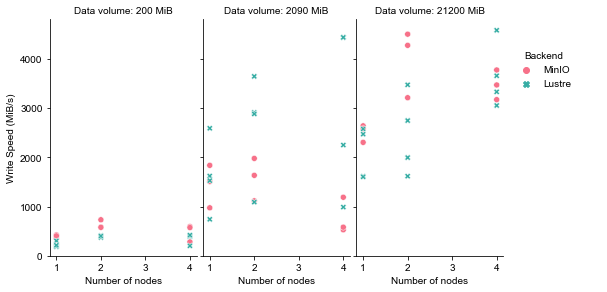

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

x_label='Number of nodes'
y_label='Write Speed (MiB/s)'
palette='husl'

g = sns.relplot(data=tmp, x='cores', y='speed(MiB/s)', col="Data volume(MiB)", hue="backend", style='backend', 
                 palette=palette, facet_kws={'sharey': True})

g.set(ylim=(0, None))
sns.set_style("whitegrid", rc={'grid.linestyle': '--'})
g.set_axis_labels(x_label, y_label)
g.set_titles(col_template="Data volume: {col_name} MiB", row_template="{row_name}")
g.tight_layout()
g.fig.set_size_inches(7.2,4)
leg = g._legend
leg.set_bbox_to_anchor([1.12, 0.77])
g._legend.set_title('Backend')
# replace labels
new_labels = ['MinIO', 'Lustre']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.savefig('./strong-small-scale.pdf')

## Plot for Scaling tests

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def sub2plot(df, cate = 'Data volume(MiB)', x_label='Number of nodes', y_label='Write Speed (MiB/s)', 
             palette='Set1', logy=True, y_type='speed(MiB/s)', sharey=True, legend=True):
    g = sns.relplot(data=df, x='cores', y=y_type, hue=cate, col='backend', 
                    style=cate, palette=palette, col_order=['lustre','minio'], legend=legend,
                   facet_kws={'sharey': sharey})
    if logy:
        g.set(yscale = 'log')
    sns.set_style("whitegrid", rc={'grid.linestyle': '--'})
    g.set_axis_labels(x_label, y_label)
    g.set_titles(col_template="Backend: {col_name}", row_template="{row_name}")
    g.tight_layout()
    g.fig.set_size_inches(7.2,3)

    axes = g.axes.flatten()
    axes[0].set_title("Lustre")
    axes[1].set_title("MinIO")
    
    if legend:
        leg = g._legend
        leg.set_bbox_to_anchor([1.1, 0.8])
    
    return g

### strong scaling speed

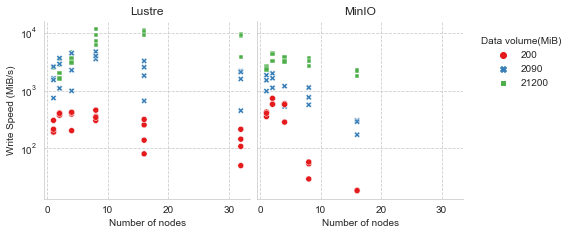

In [12]:
g = sub2plot(pd.concat([df4,df1], axis=0))
g.savefig('./strong-speed.pdf')

### strong scaling speedup

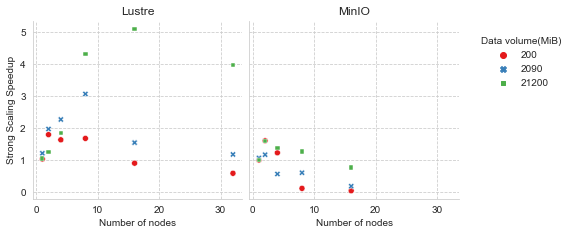

In [13]:
tmp = pd.concat([df1, df4], axis=0)
tmp = tmp[['cores','backend','speedup','Data volume(MiB)']].groupby(
    ['cores', 'backend', 'Data volume(MiB)'], as_index=False).mean()

g = sub2plot(tmp, logy=False, 
             y_type='speedup', y_label='Strong Scaling Speedup', sharey=True)
g.savefig('./strong-speedup.pdf')

### weak scaling speed

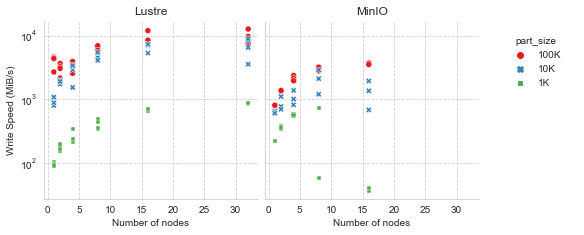

In [14]:
g = sub2plot(pd.concat([df3, df5], axis=0), cate='part_size')
g.savefig('./weak-speed.pdf')

### weak scaling efficiency

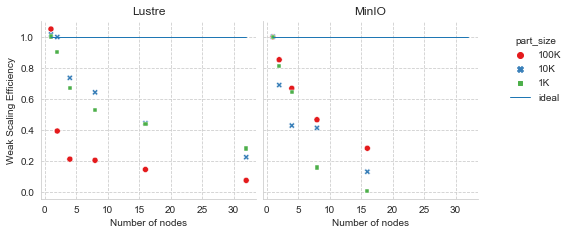

In [15]:
tmp = pd.concat([df3, df5], axis=0)
tmp = tmp[['cores','backend','speedup','part_size']].groupby(
    ['cores', 'backend', 'part_size'], as_index=False).mean()
                
g = sub2plot(tmp, logy=False, cate='part_size', 
             y_type='speedup', y_label='Weak Scaling Efficiency', legend=True)
g.axes[0][0].plot([1, 32], [1, 1], linewidth=1, label='ideal')
g.axes[0][1].plot([1, 32], [1, 1], linewidth=1, label='ideal')

plt.legend(title='', loc='upper left', bbox_to_anchor=(1.11, 0.64), frameon=False)

g.savefig('./weak-effi.pdf')

---

## Other functions that have been abandoned

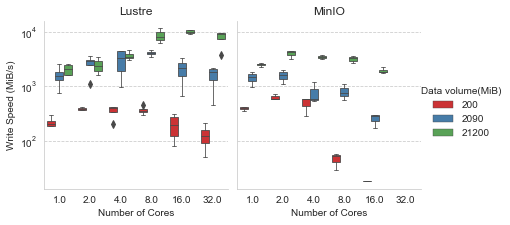

In [16]:
def boxplotsub(df, cate = 'Data volume(MiB)', x_label='Number of Cores', y_label='Write Speed (MiB/s)', 
             palette='Set1', logy=True, y_type='speed(MiB/s)', sharey=True):
    
    g = sns.catplot(x="cores", y=y_type,hue=cate, 
                col="backend",data=df, kind="box",height=4, aspect=.9, 
                    palette=palette, sharey=sharey, col_order=['lustre','minio'], linewidth=0.8)
    if logy:
        g.set(yscale = 'log')
    # g.add_legend()
    sns.set_style("whitegrid", rc={'grid.linestyle': '--'})
    g.set_axis_labels(x_label, y_label)
    g.set_titles(col_template="Backend: {col_name}", row_template="{row_name}")
    g.tight_layout()
    g.fig.set_size_inches(7,3)

    axes = g.axes.flatten()
    axes[0].set_title("Lustre")
    axes[1].set_title("MinIO")

#     plt.legend(title=cate, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    return g

g = boxplotsub(pd.concat([df4,df1], axis=0))
# g.savefig('./testt-box.pdf')

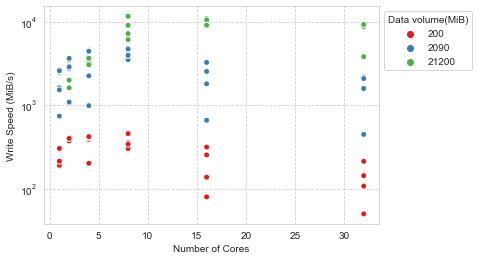

In [17]:
import seaborn as sns
# plt.style.use(['science'])

# plt.style.use('default')
def df_boxplot(df, y="speed(MiB/s)", ylabel='Write Speed (MiB/s)', cate='Data volume(MiB)',  palette="Set1"):
    fig, ax = plt.subplots()
#     ax.grid(axis="y", linestyle = '-',linewidth =1, color= 'gray',alpha = 1, zorder=0)
    sns.set_style("whitegrid", rc={'grid.linestyle': '--'})

    ax = sns.scatterplot(x="cores", y=y, hue=cate,
                     data=df, palette=palette, linewidth=1, ax=ax)
#     ax = sns.boxplot(x="cores", y=y, hue=cate,
#                      data=df, palette=palette, linewidth=1, ax=ax)
#     ax = sns.swarmplot(x="cores", y=y, hue=cate,
#                      data=df, palette=palette, size=4, linewidth=1, ax=ax, dodge=True)
#     ax = sns.stripplot(x="cores", y=y, hue=cate,
#                      data=df, palette=palette, size=7, linewidth=0.5, ax=ax, jitter=1, dodge=True)
    ax.set_yscale('log')
    ax.set_xlabel('Number of Cores')
    ax.set_ylabel(ylabel)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    


df_boxplot(df1, palette='Set1')
# plt.savefig('./strong-lustre-speed.pdf')